$\bf{Problem Statement}$: Match the APOGEE-red-clump catalog to Gaia DR2, integrate the orbits using galpy for 20 Gyr, and make a density plot in Galactocentric X and Y coordinates of all of the positions of the stars over the next 20 Gyr.

In [1]:
import astropy.units as u
import gaia_tools.load as gload
import gaia_tools.xmatch as gmatch
from galpy.potential import MWPotential2014
from galpy.orbit import Orbit
from astropy.coordinates import SkyCoord
import numpy as np
import time as time_class
import matplotlib.pyplot as plt
import os

Load the data from APOGEE red clump and cross match with gaia2

In [2]:
aprc = gload.apogeerc()
# call the cross match cds function
if os.path.exists("gaia_apogee_xmatch.csv"):
    gaia2_matches = gmatch.cds_load("gaia_apogee_xmatch.csv")
else:
    gaia2_matches, matches_indx = gmatch.cds(aprc, xcat='vizier:I/345/gaia2', savefilename = "gaia_apogee_xmatch.csv")

C:\Users\user\AppData\Roaming\Python\Python36\site-packages\gaia_tools-0.2-py3.6.egg\gaia_tools\load\__init__.py:94: UserWarning: Falling back on simple APOGEE interface; for more functionality, install the jobovy/apogee package
  warnings.warn("Falling back on simple APOGEE interface; for more functionality, install the jobovy/apogee package")



Since not all the stars have radial velocity, take out all the stars whose radial velocity is -9999.99 (an error value)

In [3]:
gaia2_matches = gaia2_matches[gaia2_matches['radial_velocity'] != -9999.99]
# store the number of stars to integrate
number_of_stars = np.size(gaia2_matches)
print('There are currently a total of {} stars.'.format(number_of_stars))

There are currently a total of 12313 stars.


Get the list of the 6 position and vleocity coordinates for all of the stars

In [4]:
ra_list = gaia2_matches['ra']
dec_list = gaia2_matches['dec']
parallax_list = gaia2_matches['parallax']
vr_list = gaia2_matches['radial_velocity']
pm_ra_list = gaia2_matches['pmra']
pm_dec_list = gaia2_matches['pmdec']

Create an orbit object for each star. Give user the option to use saved data.

In [ ]:
use_saved = input("Do you want to use saved data? (y/n)")
if use_saved ==  'n':
    file_name = input("File name to store the star coordinates data (without extension): ")
    file_name = file_name + '.npz'
    
    #Since there are a lot of stars, if user only wants to test a subset of the stars, they can set the list to the first few
    number_of_stars = int(input("Enter the number of stars you want to work with (has to be lower than current number):"))
    
    #Initialize variable needed for integrating orbit and storing the results
    # create time step array
    total_year = 20 # in giga year unit
    number_of_time_interval = 100 # divide total_year into this many time steps
    ts = np.linspace(0,total_year, number_of_time_interval)*u.Gyr
    # initialize orbit list
    o = []
    # initialize numpy array to store the list of star coordinate
    star_coord_x = np.empty((number_of_time_interval, number_of_stars))
    star_coord_y = np.empty((number_of_time_interval, number_of_stars))
    
    # initialize start time
    start= time_class.time()
    for i in range(number_of_stars):
        # for each star, get the 6 coordinates from list
        ra, dec, parallax, vr, v_ra, v_dec = ra_list[i], dec_list[i], parallax_list[i], vr_list[i], pm_ra_list[i], pm_dec_list[i]
        # use parallex to find radial distance
        d = 1/parallax # since parallax is given in milliarcsecond, its inverse is kpc

        # create orbit object
        # the units are already in desired form, radec = True means we are using righ ascention - declination initialization format
        # in order for galpy to output physical unit, we need to set radius and velocity scale
        o.append(Orbit(vxvv = [ra,dec,d,v_ra, v_dec,vr], radec = True, ro = 8., vo = 220.)) 
        # for each star, integrate their orbit over the next 20 Gyr using the most up-to-date Milky Way potential
        o[i].integrate(ts,MWPotential2014)

        # print out progess report and time taken
        if i%100 == 0:
            time_elapsed = time_class.time() - start
            print("Completed: {} %, time taken: {} ".format(i/number_of_stars*100, time_elapsed))
    
    # get all the star x, y coordinate
    star_coord_x = np.stack([orbit.x(ts) for orbit in o])
    star_coord_y = np.stack([orbit.y(ts) for orbit in o])

    # save the star coordinate array
    np.savez(file_name, star_coord_x = star_coord_x, star_coord_y = star_coord_y )
    
elif use_saved ==  'y':
    file_name = input("File name to be opened (without extension): ")
    file_name = file_name + '.npz'
    data = np.load(file_name)
    star_coord_x = data['star_coord_x']
    star_coord_y = data['star_coord_y']
    
else:
    raise Exception("Answer must be (y/n)")

Do you want to use saved data? (y/n)n
File name to store the star coordinates data (without extension): Coordinates of all stars
Enter the number of stars you want to work with (has to be lower than current number):12313
integrated star  0
Completed: 0.0 %, time taken: 1.7561004161834717 
integrated star  1
integrated star  2
integrated star  3
integrated star  4
integrated star  5
integrated star  6
integrated star  7
integrated star  8
integrated star  9
integrated star  10
integrated star  11
integrated star  12
integrated star  13
integrated star  14
integrated star  15
integrated star  16
integrated star  17
integrated star  18
integrated star  19


In [7]:
# create a list of all x and y position over all time
list_of_all_x = star_coord_x.flatten()
list_of_all_y = star_coord_y.flatten()

Populating the interactive namespace from numpy and matplotlib


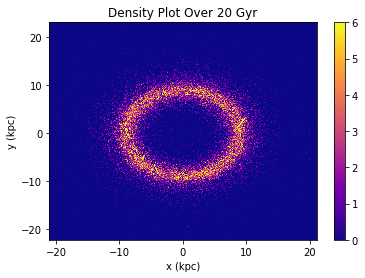

In [17]:
%pylab inline

plt.hist2d(list_of_all_x,list_of_all_y, bins = 300, cmap = 'plasma', vmin = 0 , vmax = 6)
plt.colorbar()
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.title('Density Plot Over 20 Gyr')
plt.savefig("Density Plot Over 20 Gyr.pdf")